# TUTORIAL: TRANSFERENCIA DE APRENDIZAJE + VISIÓN POR COMPUTADOR

La transferencia de aprendizaje es una técnica muy útil para poder crear modelos de Deep Learning cuando tenemos pocos datos o recursos computacionales limitados.

Así que en este tutorial veremos de forma práctica cómo usar la transferencia de aprendizaje para construir un clasificador de imágenes partiendo de un modelo pre-entrenado y disponible en Internet.

Contenido:

1. [¿Qué es la transferencia de aprendizaje?](#scrollTo=P3-oDJaVqt-C&line=1&uniqifier=1)
2. [El problema a resolver](#scrollTo=xZfOLXw1s5rS)
3. [El set de datos](#scrollTo=brSYIXlAtHeh)
4. [La transferencia de aprendizaje](#scrollTo=ucnyE0B9U00R&line=8&uniqifier=1)
5. [Conclusiones](#scrollTo=3p5xzKkzTp-e&line=1&uniqifier=1)

## 1. ¿Qué es la transferencia de aprendizaje?

En un [video anterior] hablamos de esta técnica que esencialmente consiste en aprovechar un modelo que ha sido previamente entrenado para una tarea **similar** (pero no idéntica) a la que nos interesa, tomar este modelo, modificar sus capas de salida y re-entrenarlo para especializarlo en una nueva tarea:

![](https://drive.google.com/uc?export=view&id=1M6dmaHk724DmS06ahrRKnkbt3vu_LhK4)

## 2. El problema a resolver

> Crear un modelo (red convolucional) capaz de clasificar imágenes satelitales usando transferencia de aprendizaje

## 3. El set de datos

Usaremos el set de datos [EuroSAT] que contiene imágenes satelitales de la superficie terrestre etiquetadas en 10 diferentes categorías:

- *AnnualCrop*: cultivo anual (estacional)
- *Forest*: bosque
- *HerbaceousVegetation*: vegetación de hierba
- *Highway*: autopista
- *Industrial*: uso industrial
- *Pasture*: pastoreo
- *PermanentCrop*: cultivo permanente
- *Residential*: uso residencial
- *River*: río
- *SeaLake*: cuerpo de agua (mar o lago)

En total el set de datos contiene 27.000 imágenes en formato RGB y un tamaño aproximado de casi 90MB.

Podemos descargar fácilmente los datos como un dataset de TensorFlow usando el módulo `tensorflow_datasets`:

In [1]:
# Importar librerías
import tensorflow as tf
import tensorflow_datasets as tfds

# Cargar el dataset con "load"
ds, ds_info = tfds.load(
    "eurosat",             # Nombre del dataset
    with_info = True,      # Cargar nombres de etiquetas
    shuffle_files = True,  # Mezclar datos
    split = ["train[:80%]", "train[80%:90%]", "train[90%:]"], # Entrenamiento, validación y prueba
    as_supervised=True,    # Incluir etiquetas (categorías numéricas)
    read_config = tfds.ReadConfig(shuffle_seed=23), # Semilla del generador aleatorio
)

# Extraer los sets de entrenamiento, validación y prueba
train, val, test = ds[0], ds[1], ds[2]

# Imprimir información en pantalla
print(f'Tamaño del set de entrenamiento: {len(train)}')
print(f'Tamaño del set de validación: {len(val)}')
print(f'Tamaño del set de prueba: {len(test)}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incomplete3Q97SB/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
Tamaño del set de entrenamiento: 21600
Tamaño del set de validación: 2700
Tamaño del set de prueba: 2700


Y podemos usar el método `show_examples` para rápidamente ver algunas imágenes del set de datos:

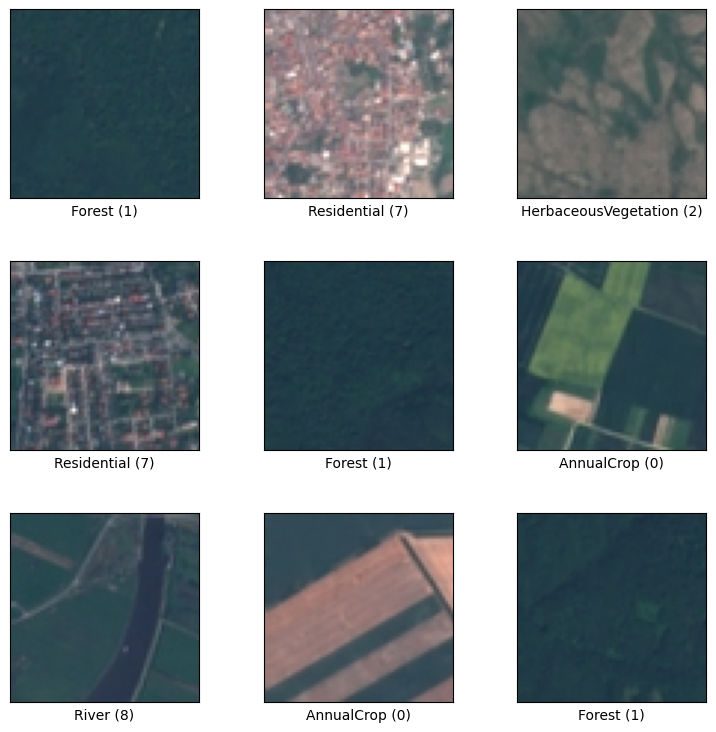

In [2]:
tfds.show_examples(train, ds_info);

Extraigamos una imagen para ver algunas de las características del dato:

In [3]:
for img, lbl in train.take(1):
    print(f'Mínimo y máximo: {img.numpy().min()}, {img.numpy().max()}')
    print(f'Tipo de dato: {img.dtype}')
    print(f'Tamaño: {img.get_shape()}')

Mínimo y máximo: 26, 98
Tipo de dato: <dtype: 'uint8'>
Tamaño: (64, 64, 3)


Cada imagen es de 64x64x3 y está almacenada en el formato *uint8* (es decir que los pixeles están entre 0 y 255).

Tengamos esto en cuenta para el pre-procesamiento que haremos en un momento.

## 4. La transferencia de aprendizaje

Usaremos una red convolucional pre-entrenada como la base de nuestro clasificador.

Lo que haremos será quitarle la capa de salida y reemplazarla por una capa adecuada para nuestro problema, y luego entrenaremos **únicamente** esta capa de salida (no se modificará el modelo pre-entrenado):


![](https://drive.google.com/uc?export=view&id=1M8s_pf6CD5bcZKjHKTWn63SIVPVFxLuA)

### 4.1. El modelo pre-entrenado

Usaremos el modelo [Xception](https://keras.io/api/applications/xception/) (disponible directamente desde el repositorio de Keras).

Algunas características importantes de este modelo:

- Red Convolucional con casi 23 millones de parámetros
- Entrenada con el set ImageNet (1.2 millones de imágenes, más de 20.000 categorías)
- Tamaño mínimo de entrada: 71x71x3
- Tipo de dato de entrada: *float32* y valores entre -1 y 1


Si tenemos en cuenta estas características y las características de nuestras imágenes en el set de datos vemos que es necesario implementar una fase de pre-procesamiento que:

- Convierta cada imagen de 64x64x3 a 71x71x3
- Convierta cada imagen en formato *uint8* a *float32*
- Escale los pixeles al rango de -1 a 1

Todo esto lo podemos lograr implementando la función `preprocesar`:

In [4]:
# Función para pre-procesar una imagen
# Se incluye como argumento de entrada la categoría
# (pues este elemento será necesario al aplicar esta
# función al dataset)

def preprocesar(img, lbl):
    # Redimensionar la imagen a 71x71
    img = tf.image.resize(img, (71,71))

    # Escalar los pixeles: 0->-1 y 255->1 y
    # convertir a float32
    img = tf.image.convert_image_dtype(img/127.5-1, dtype=tf.float32)

    return img, lbl

Usaremos esta función cuando le presentemos el dataset de TensorFlow al modelo que entrenaremos.

Sin embargo, verifiquemos que la función realiza las transformaciones requeridas:

In [5]:
for img, lbl in train.map(preprocesar).take(1):
    print(f'Mínimo y máximo: {img.numpy().min()}, {img.numpy().max()}')
    print(f'Tipo de dato: {img.dtype}')
    print(f'Tamaño: {img.get_shape()}')

Mínimo y máximo: -0.7836509346961975, -0.2982698678970337
Tipo de dato: <dtype: 'float32'>
Tamaño: (71, 71, 3)


### 4.2. Implementación del modelo con transferencia de aprendizaje

Comenzaremos descargando el modelo pre-entrenado del repositorio de Keras:

In [ ]:
import tensorflow.keras as keras
tf.random.set_seed(123) # Para la reproducibilidad del entrenamiento

# Modelo pre-entrenado
xception = keras.applications.Xception(
    weights = "imagenet",
    input_shape = (71,71,3),
    include_top = False, # No incluir la capa de salida
)

# Imprimir características del modelo
xception.summary()

Este modelo tiene casi 21 millones de parámetros entrenables. Congelemos estos parámetros pues no queremos re-entrenar este modelo:

In [ ]:
xception.trainable = False

xception.summary()

Y ahora usemos este modelo "congelado" como base para nuestro clasificador.

La estructura será:

MODELO = CAPA DE ENTRADA --> XCEPTION (CONGELADO) --> CAPA DE SALIDA

Así que simplemente debemos crear las capas de entrada y de salida y conectarlas al modelo pre-entrenado:

Model: "modelo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Entrada (InputLayer)        [(None, 71, 71, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 Aplanar (Flatten)           (None, 18432)             0         
                                                                 
 Dense (Dense)               (None, 128)               2359424   
                                                                 
 Dropout (Dropout)           (None, 128)               0         
                                                                 
 Salida (Dense)              (None, 10)                1290      
                                                                 
Total params: 23222194 (88.59 MB)
Trainable params: 2360714 

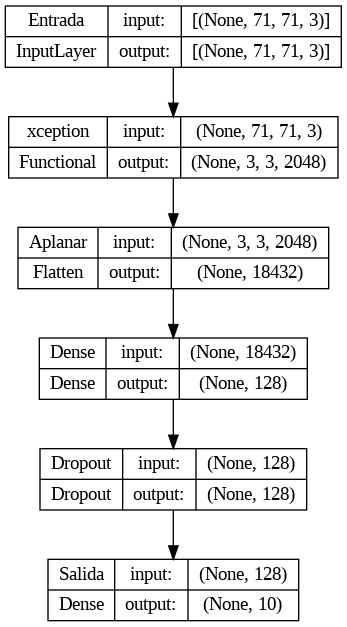

In [9]:
# Número de categorías (10)
NUM_CLASES = ds_info.features['label'].num_classes

# Capa de entrada
entrada = keras.Input(shape=(71, 71, 3), name='Entrada')

# Conectar entrada al modelo pre-entrenado: x = entrada + xception
x = xception(entrada)

# Crear salida y conectarla a la entrada

# 1. Capa flatten para aplanar el volumen generado por xception
# x = entrada + xception + flatten
x = keras.layers.Flatten(name='Aplanar')(x)

# 2. Capa "Dense" con 128 neuronas
# x = entrada + xception + flatten + Dense 128
x = keras.layers.Dense(128, activation='relu', name='Dense')(x)

# 3. Capa "Dropout" para reducir overfitting
# x = entrada + xception + flatten + Dense 128 + Dropout
x = keras.layers.Dropout(0.5, name='Dropout')(x)

# 4. Capa "Dense" con 10 neuronas de salida
# x = entrada + xception + flatten + Dense 128 + Dropout + Dense 10
salida = keras.layers.Dense(NUM_CLASES, activation='softmax', name='Salida')(x)

# Y conectar "entrada" y "salida" para crear el modelo
# MODELO = CAPA DE ENTRADA --> XCEPTION (CONGELADO) --> CAPA DE SALIDA
modelo = keras.Model(entrada, salida, name='modelo')

# Imprimamos en pantalla las características del modelo
modelo.summary()

# Y dibujemos los bloques que hacen parte del modelo
keras.utils.plot_model(modelo, show_shapes=True)

Y acá vemos varias cosas importantes:

1. La salida de xception es un volumen de 3x3x2048 que es aplanado por la capa "Aplanar" y convertido en un vector de 18.432 (=3x3x2048)
2. El número total de parámetros es de un poco más de 23 millones, de los cuales:
   - 2.3 millones son entrenables y corresponden a las capas "Dense_1" y "Salida"
   - Mientras que 20.8 millones son **NO** entrenables, y corresponden a "xception".

Y en este punto ya tenemos nuestro modelo listo para entrenar.

Como el set de datos es muy grande para evitar problemas de consumo de memoria RAM usaremos lotes de 32 imágenes tanto para entrenar como para validar:

In [10]:
BATCH_SIZE = 32

# Crear lotes de entrenamiento, validación y prueba
train_batch = train.map(preprocesar).batch(BATCH_SIZE)
val_batch = val.map(preprocesar).batch(BATCH_SIZE)
test_batch = test.map(preprocesar).batch(BATCH_SIZE)

Es importante tener en cuenta que en este punto aún no se han cargado en memoria los lotes. Esto se hará cuando comencemos a entrenar el modelo:

In [11]:
# Compilar el modelo
modelo.compile(
    optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

# Y entrenarlo por 10 iteraciones
epochs = 10
modelo.fit(train_batch, epochs=epochs, validation_data=val_batch)

Epoch 1/10
675/675 [==============================] - 33s 30ms/step - loss: 1.0766 - sparse_categorical_accuracy: 0.6822 - val_loss: 0.5716 - val_sparse_categorical_accuracy: 0.8189
Epoch 2/10
675/675 [==============================] - 20s 30ms/step - loss: 0.7485 - sparse_categorical_accuracy: 0.7614 - val_loss: 0.5279 - val_sparse_categorical_accuracy: 0.8304
Epoch 3/10
675/675 [==============================] - 19s 29ms/step - loss: 0.6703 - sparse_categorical_accuracy: 0.7881 - val_loss: 0.5383 - val_sparse_categorical_accuracy: 0.8344
Epoch 4/10
675/675 [==============================] - 19s 28ms/step - loss: 0.5941 - sparse_categorical_accuracy: 0.8067 - val_loss: 0.5137 - val_sparse_categorical_accuracy: 0.8400
Epoch 5/10
675/675 [==============================] - 19s 28ms/step - loss: 0.5506 - sparse_categorical_accuracy: 0.8217 - val_loss: 0.4851 - val_sparse_categorical_accuracy: 0.8474
Epoch 6/10
675/675 [==============================] - 19s 28ms/step - loss: 0.5190 - spars

## 5. Conclusiones

Muy bien, acabamos de ver que es relativamente sencillo crear un modelo clasificador haciendo uso de la transferencia de aprendizaje.

En últimas la idea es buscar un modelo entrenado previamente para una tarea similar, que en este caso es la clasificación de imágenes, "congelar" la parte central de este modelo (es decir las capas convolucionales), agregar la capa de salida y entrenar el nuevo modelo por unas cuantas iteraciones.

Y en este sencillo ejemplo hemos visto que hemos podido aprovechar las capacidades del modelo pre-entrenado para especializarlo en una tarea que en este caso era la clasificación de imágenes satelitales.

Así que pueden descargar el código fuente del enlace que encontrarán en la descripción y pueden intentar afinar el modelo que acabamos de crear, cambiando por ejemplo parámetros como el dropout o el número de neuronas en la capa de salida o por ejemplo el tamaño del lote o el número de iteraciones, para intentar así mejorar el desempeño que obtuvimos que era cercano al 85%.